##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# NumPy API on TensorFlow

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/guide/tf_numpy"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/guide/tf_numpy.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/guide/tf_numpy.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/guide/tf_numpy.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Overview

TensorFlow implements a subset of the [NumPy API](https://numpy.org/doc/1.16), available as `tf.experimental.numpy`. This allows running NumPy code, accelerated by TensorFlow, while also allowing access to all of TensorFlow's APIs.

## Setup

Note: `tf.experimental.numpy` will be available in the stable branch starting from TensorFlow 2.4. For now, it is available in `nightly`.

In [2]:
!pip install --quiet --upgrade tf-nightly

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.experimental.numpy as tnp
import timeit

print("Using TensorFlow version %s" % tf.__version__)

Using TensorFlow version 2.4.0-dev20200804


## TensorFlow NumPy ND array

An instance of `tf.experimental.numpy.ndarray`, which we will call **ND Array**, represents a multidimensional dense array of a given `dtype` placed on a certain device. Each one of these objects internally wraps a `tf.Tensor`. Check out the ND array class for useful methods like `ndarray.T`, `ndarray.reshape`, `ndarray.ravel` and others.

First create an ND array object, and then invoke different methods. 

In [4]:
# Create an ND array and check out different attributes.
ones = tnp.ones([5, 3], dtype=tnp.float32)
print("Created ND array with shape = %s, rank = %s, "
      "dtype = %s on device = %s\n" % (
          ones.shape, ones.ndim, ones.dtype, ones.data.device))

# Check out the internally wrapped `tf.Tensor` object.
print("The ND array wraps a tf.Tensor: %s\n" % ones.data)

# Try commonly used member functions.
print("ndarray.T has shape %s" % str(ones.T.shape))
print("narray.reshape(-1) has shape %s" % ones.reshape(-1).shape)

Created ND array with shape = (5, 3), rank = 2, dtype = float32 on device = /job:localhost/replica:0/task:0/device:GPU:0

The ND array wraps a tf.Tensor: tf.Tensor(
[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]], shape=(5, 3), dtype=float32)

ndarray.T has shape (3, 5)
narray.reshape(-1) has shape 15


### Type promotion

TensorFlow NumPy APIs have well-defined semantics for converting literals to ND array, as well as for performing type promotion on ND array inputs. Please see [`np.result_type`](https://numpy.org/doc/stable/reference/generated/numpy.result_type.html) for more details. . When converting literals to ND array, NumPy prefers wide types like `tnp.int64` and `tnp.float64`.

In contrast, `tf.convert_to_tensor` prefers `tf.int32` and `tf.float32` types for converting constants to `tf.Tensor`. TensorFlow APIs leave `tf.Tensor` inputs unchanged and do not perform type promotion on them.

In the next example, you will perform type promotion. First, run addition on ND array inputs of different types and note the output types. None of these type promotions would be allowed on straight `tf.Tensor` objects. Finally,
convert literals to ND array using `ndarray.asarrray` and note the resulting type.

In [5]:
print("Type promotion for operations")
values = [tnp.asarray(1, dtype=d) for d in
          (tnp.int32, tnp.int64, tnp.float32, tnp.float64)]
for i, v1 in enumerate(values):
  for v2 in values[i+1:]:
    print("%s + %s => %s" % (v1.dtype, v2.dtype, (v1 + v2).dtype))

print("Type inference during array creation")
print("tnp.asarray(1).dtype == tnp.%s" % tnp.asarray(1).dtype)
print("tnp.asarray(1.).dtype == tnp.%s\n" % tnp.asarray(1.).dtype)


Type promotion for operations
int32 + int64 => int64
int32 + float32 => float64
int32 + float64 => float64
int64 + float32 => float64
int64 + float64 => float64
float32 + float64 => float64
Type inference during array creation
tnp.asarray(1).dtype == tnp.int64
tnp.asarray(1.).dtype == tnp.float64



### Broadcasting

Similar to TensorFlow, NumPy defines rich semantics for "broadcasting" values.
Checkout the [NumPy broadcasting guide](https://numpy.org/doc/stable/user/basics.broadcasting.html). Also compare this with [TensorFlow broadcasting semantics](https://www.tensorflow.org/guide/tensor#broadcasting).


In [6]:
x = tnp.ones([2, 3])
y = tnp.ones([3])
z = tnp.ones([1, 2, 1])
print("Broadcasting shapes %s, %s and %s gives shape %s" % (
    x.shape, y.shape, z.shape, (x + y + z).shape))

Broadcasting shapes (2, 3), (3,) and (1, 2, 1) gives shape (1, 2, 3)


### Indexing

NumPy defines very sophistsicated indexing rules. See the [NumPy Indexing guide](https://numpy.org/doc/stable/reference/arrays.indexing.html). Note the use of ND arrays as indices below.

In [7]:
x = tnp.arange(24).reshape(2, 3, 4)

print("Basic indexing")
print(x[1, tnp.newaxis, 1:3, ...], "\n")

print("Boolean indexing")
print(x[:, (True, False, True)], "\n")

print("Advanced indexing")
print(x[1, (0, 0, 1), tnp.asarray([0, 1, 1])])

Basic indexing
ndarray<tf.Tensor(
[[[16 17 18 19]
  [20 21 22 23]]], shape=(1, 2, 4), dtype=int64)> 

Boolean indexing
ndarray<tf.Tensor(
[[[ 0  1  2  3]
  [ 8  9 10 11]]

 [[12 13 14 15]
  [20 21 22 23]]], shape=(2, 2, 4), dtype=int64)> 

Advanced indexing
ndarray<tf.Tensor([12 13 17], shape=(3,), dtype=int64)>


In [8]:
# Mutation is currently not supported
try:
  tnp.arange(6)[1] = -1
except TypeError:
  print("Currently, TensorFlow NumPy does not support mutation.")

Currently, TensorFlow NumPy does not support mutation.


### Example Model

Next, you can see how to create a model and run inference on it. This simple model applies a relu layer followed by a linear projection. Later sections will show how to compute gradients for this model using TensorFlow's `GradientTape`.

In [9]:
class Model(object):
  """Model with a dense and a linear layer."""

  def __init__(self):
    self.weights = None

  def predict(self, inputs):
    if self.weights is None:
      size = inputs.shape[1]
      # Note that we use `tnp.float32` type for performance.
      stddev = tnp.sqrt(size).astype(tnp.float32)
      w1 = tnp.random.randn(size, 64).astype(tnp.float32) / stddev
      bias = tnp.random.randn(64).astype(tnp.float32)
      w2 = tnp.random.randn(64, 2).astype(tnp.float32) / 8
      self.weights = (w1, bias, w2)
    else:
      w1, bias, w2 = self.weights
    y = tnp.matmul(inputs, w1) + bias
    y = tnp.maximum(y, 0)  # Relu
    return tnp.matmul(y, w2)  # Linear projection

model = Model()
# Create input data and compute predictions.
print(model.predict(tnp.ones([2, 32], dtype=tnp.float32)))

ndarray<tf.Tensor(
[[0.10091628 0.88749623]
 [0.10091628 0.88749623]], shape=(2, 2), dtype=float32)>


## TensorFlow NumPy and NumPy

TensorFlow NumPy implements a subset of the full NumPy spec. While more symbols will be added over time, there are systematic features that will not be supported in the near future. These include NumPy C API support, Swig integration, Fortran storage order, views and `stride_tricks`, and some dtypes (like `np.recarray`, `np.object`). For more details, please see the [TensorFlow NumPy API Documentation](https://www.tensorflow.org/api_docs/python/tf/experimental/numpy)



### NumPy interoperability

TensorFlow ND arrays can interoperate with NumPy functions. These objects implement the `__array__` interface. NumPy uses this interface to convert function arguments to `np.ndarray` values before processing them.

Similarly, TensorFlow NumPy functions can accept inputs of different types including `tf.Tensor` and `np.ndarray`. These input are converted to ND array by calling `ndarray.asarray` on them. 

Conversion of ND array to and from `np.ndarray` may trigger actual data copies. Please see section on [buffer copies](#Buffer-copies) for more details.

In [10]:
# ND array passed into NumPy function.
np_sum = np.sum(tnp.ones([2, 3]))
print("sum = %s. Class: %s" % (float(np_sum), np_sum.__class__))

# `np.ndarray` passed into TensorFlow NumPy function.
tnp_sum = tnp.sum(np.ones([2, 3]))
print("sum = %s. Class: %s" % (float(tnp_sum), tnp_sum.__class__))

sum = 6.0. Class: <class 'numpy.float64'>
sum = 6.0. Class: <class 'tensorflow.python.ops.numpy_ops.np_arrays.ndarray'>


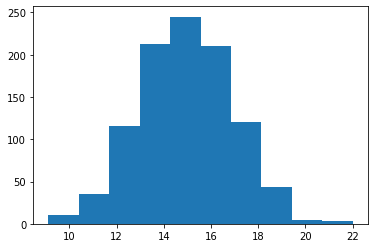

In [11]:
# It is easy to plot ND arrays, given the __array__ interface.
labels = 15 + 2 * tnp.random.randn(1000)
_ = plt.hist(labels)

### Buffer copies

Intermixing TensorFlow NumPy with NumPy code may trigger data copies. This is because TensorFlow NumPy has stricter requirments on memory alignment than those of NumPy.

When a `np.ndarray` is passed to TensorFlow Numpy, it will check for alignment requirements and trigger a copy if needed. When passing an ND array CPU buffer to NumPy, generally the buffer will satisfy alignment requirements and NumPy will not need to create a copy.

ND arrays can refer to buffers placed on devices other than the local CPU memory. In such cases, invoking a NumPy function will trigger copies across the network or device as needed.

Given this, intermixing with NumPy API calls should generally be done with caution and the user should watch out for overheads of copying data. Interleaving TensorFlow NumPy calls with TensorFlow calls is generally safe and avoids copying data. See the section on [tensorflow interoperability](#Tensorflow-interoperability) for more details.

### Operator precedence

TensorFlow NumPy defines an `__array_priority__` higher than NumPy's. This means that for operators involving both ND array and `np.ndarray`, the former will take precedence, i.e., `np.ndarray` input will get converted to an ND array and the TensorFlow NumPy implementation of the operator will get invoked.

In [12]:
x = tnp.ones([2]) + np.ones([2])
print("x = %s\nclass = %s" % (x, x.__class__))

x = ndarray<tf.Tensor([2. 2.], shape=(2,), dtype=float64)>
class = <class 'tensorflow.python.ops.numpy_ops.np_arrays.ndarray'>


## TF NumPy and TensorFlow

TensorFlow NumPy is built on top of TensorFlow and hence interoperates seamlessly with TensorFlow.

### `tf.Tensor` and ND array

ND array is a thin wrapper on `tf.Tensor`. These types can be converted cheaply to one another without triggering actual data copies.

In [13]:
x = tf.constant([1, 2])

# Convert `tf.Tensor` to `ndarray`.
tnp_x = tnp.asarray(x)
print(tnp_x)

# Convert `ndarray` to `tf.Tensor` can be done in following ways.
print(tnp_x.data)
print(tf.convert_to_tensor(tnp_x))

# Note that tf.Tensor.numpy() will continue to return `np.ndarray`.
print(x.numpy(), x.numpy().__class__)

ndarray<tf.Tensor([1 2], shape=(2,), dtype=int32)>
tf.Tensor([1 2], shape=(2,), dtype=int32)
tf.Tensor([1 2], shape=(2,), dtype=int32)
[1 2] <class 'numpy.ndarray'>


### TensorFlow interoperability

ND array can be passed to TensorFlow APIs. These calls internally convert  ND array inputs to `tf.Tensor`. As mentioned earlier, such conversion does not actually do data copies, even for data placed on accelerators or remote devices.

Conversely, `tf.Tensor` objects can be passed to `tf.experimental.numpy` APIs. These inputs will internally be converted to ND array without performing data copies.

In [14]:
# ND array passed into TensorFlow function.
# This returns a `tf.Tensor`.
tf_sum = tf.reduce_sum(tnp.ones([2, 3], tnp.float32))
print("Output = %s" % tf_sum)

# `tf.Tensor` passed into TensorFlow NumPy function.
# This returns an ND array.
tnp_sum = tnp.sum(tf.ones([2, 3]))
print("Output = %s" % tnp_sum)

Output = tf.Tensor(6.0, shape=(), dtype=float32)
Output = ndarray<tf.Tensor(6.0, shape=(), dtype=float32)>


#### Operator precedence

When ND array and `tf.Tensor` objects are combined using operators, a precedence rule is used to determine which object executes the operator. This is controllled by the `__array_priority__` value defined by these classes.

`tf.Tensor` defines an `__array_priority__` higher than that of ND array. This means that the ND array input will be converted to `tf.Tensor` and the `tf.Tensor` version of the operator will be called. 

The code below demonstrates how that affects the output type.


In [15]:
x = tnp.ones([2, 2]) + tf.ones([2, 1])
print("x = %s\nClass = %s" % (x, x.__class__))

x = tf.Tensor(
[[2. 2.]
 [2. 2.]], shape=(2, 2), dtype=float32)
Class = <class 'tensorflow.python.framework.ops.EagerTensor'>


### Gradients and Jacobians: tf.GradientTape

TensorFlow's GradientTape can be used for backpropagation through TensorFlow and TensorFlow NumPy code. GradientTape APIs can also return ND array outputs.

Use the model created in [Example Model](#example-modle) section, and compute gradients and jacobians.

In [16]:
def create_batch(batch_size=32):
  """Creates a batch of input and labels."""
  return (tnp.random.randn(batch_size, 32).astype(tnp.float32),
          tnp.random.randn(batch_size, 2).astype(tnp.float32))

def compute_gradients(model, inputs, labels):
  """Computes gradients of squared loss between model prediction and labels."""
  with tf.GradientTape() as tape:
    assert model.weights is not None
    # Note that `model.weights` need to be explicitly watched since they
    # are not tf.Variables.
    tape.watch(model.weights)
    # Compute prediction and loss
    prediction = model.predict(inputs)
    loss = tnp.sum(tnp.square(prediction - labels))
  # This call computes the gradient through the computation above.
  return tape.gradient(loss, model.weights)

inputs, labels = create_batch()
gradients = compute_gradients(model, inputs, labels)

# Inspect the shapes of returned gradients to verify they match the
# parameter shapes.
print("Parameter shapes:", [w.shape for w in model.weights])
print("Gradient shapes:", [g.shape for g in gradients])
# Verify that gradients are of type ND array.
assert isinstance(gradients[0], tnp.ndarray)

Parameter shapes: [(32, 64), (64,), (64, 2)]
Gradient shapes: [(32, 64), (64,), (64, 2)]


In [17]:
# Computes a batch of jacobians. Each row is the jacobian of an element in the
# batch of outputs w.r.t the corresponding input batch element.
def prediction_batch_jacobian(inputs):
  with tf.GradientTape() as tape:
    tape.watch(inputs)
    prediction = model.predict(inputs)
  return prediction, tape.batch_jacobian(prediction, inputs)

inp_batch = tnp.ones([16, 32], tnp.float32)
output, batch_jacobian = prediction_batch_jacobian(inp_batch)
# Note how the batch jacobian shape relates to the input and output shapes.
print("Output shape: %s, input shape: %s" % (output.shape, inp_batch.shape))
print("Batch jacobian shape:", batch_jacobian.shape)

Output shape: (16, 2), input shape: (16, 32)
Batch jacobian shape: (16, 2, 32)


### Trace compilation: tf.function

Tensorflow's `tf.function` works by "trace compiling" the code and then optimizing these traces for much faster performance. See the [Introduction to Graphs and Functions](./guide/intro_to_graphs).

`tf.function` can be used to optimize TensorFlow NumPy code as well. Here is a simple example to demonstrate the speedups. Note that the body of `tf.function` code includes calls to TensorFlow NumPy APIs, and the inputs and output are ND arrays.


In [18]:
inputs, labels = create_batch(512)
print("Eager performance")
compute_gradients(model, inputs, labels)
print(timeit.timeit(lambda: compute_gradients(model, inputs, labels),
                    number=10)* 100, "ms")

print("\ntf.function compiled performance")
compiled_compute_gradients = tf.function(compute_gradients)
compiled_compute_gradients(model, inputs, labels)  # warmup
print(timeit.timeit(lambda: compiled_compute_gradients(model, inputs, labels),
                    number=10) * 100, "ms")

Eager performance


1.088315800006967 ms

tf.function compiled performance


0.3018564999820228 ms


### Vectorization: tf.vectorized_map

TensorFlow has inbuilt support for vectorizing parallel loops, which allows speedups of one to two orders of magnitude. These speedups are accessible via `tf.vectorized_map` API and apply to TensorFlow NumPy code as well.

It is sometimes useful to compute the gradient of each output in a batch w.r.t. the corresponding input batch element. Such computation can be done efficiently using `tf.vectorized_map` as shown below.

In [19]:
@tf.function
def vectorized_per_example_gradients(inputs, labels):
  def single_example_gradient(arg):
    inp, label = arg
    return compute_gradients(model,
                             tnp.expand_dims(inp, 0),
                             tnp.expand_dims(label, 0))
  # Note that a call to `tf.vectorized_map` semantically maps
  # `single_example_gradient` over each row of `inputs` and `labels`.
  # The interface is similar to `tf.map_fn`.
  # The underlying machinery vectorizes away this map loop which gives
  # nice speedups.
  return tf.vectorized_map(single_example_gradient, (inputs, labels))

batch_size = 128
inputs, labels = create_batch(batch_size)

per_example_gradients = vectorized_per_example_gradients(inputs, labels)
for w, p in zip(model.weights, per_example_gradients):
  print("Weight shape: %s, batch size: %s, per example gradient shape: %s " % (
      w.shape, batch_size, p.shape))

Weight shape: (32, 64), batch size: 128, per example gradient shape: (128, 32, 64) 
Weight shape: (64,), batch size: 128, per example gradient shape: (128, 64) 
Weight shape: (64, 2), batch size: 128, per example gradient shape: (128, 64, 2) 


In [20]:
# Here we benchmark the vectorized computation above and compare with
# unvectorized sequential computation using `tf.map_fn`.
@tf.function
def unvectorized_per_example_gradients(inputs, labels):
  def single_example_gradient(arg):
    inp, label = arg
    output = compute_gradients(model,
                               tnp.expand_dims(inp, 0),
                               tnp.expand_dims(label, 0))
    return output

  return tf.map_fn(single_example_gradient, (inputs, labels),
                   fn_output_signature=(tf.float32, tf.float32, tf.float32))

print("Running vectorized computaton")
print(timeit.timeit(lambda: vectorized_per_example_gradients(inputs, labels),
                    number=10) * 100, "ms")

print("\nRunning unvectorized computation")
per_example_gradients = unvectorized_per_example_gradients(inputs, labels)
print(timeit.timeit(lambda: unvectorized_per_example_gradients(inputs, labels),
                    number=5) * 200, "ms")

Running vectorized computaton
0.2887611999994988 ms

Running unvectorized computation


31.144378799945116 ms


### Device placement

TensorFlow NumPy can place operations on CPUs, GPUs, TPUs and remote devices. It uses standard TensorFlow mechanisms for device placement. Below we show a simple example to list all device and then place some computaton on a particular device.

TenorFlow also has APIs for replicating computation across devices and performing collective reductions which will not be covered here.

#### List devices

`tf.config.list_logical_devices` and `tf.config.list_physical_devices` can be used to find what devices to use.

In [21]:
print("All logical devices:", tf.config.list_logical_devices())
print("All physical devices:", tf.config.list_physical_devices())

# Try to get the GPU device. If unavailable, fallback to CPU.
try:
  device = tf.config.list_logical_devices(device_type="GPU")[0]
except IndexError:
  device = "/device:CPU:0"

All logical devices: [LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:XLA_CPU:0', device_type='XLA_CPU'), LogicalDevice(name='/device:XLA_GPU:0', device_type='XLA_GPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]
All physical devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


#### Placing operations: **`tf.device`**

Operations can be placed on a device by calling it in a `tf.device` scope.


In [22]:
print("Using device: %s" % str(device))
# Run operations in the `tf.device` scope.
# If a GPU is available, these operations execute on the GPU and outputs are
# placed on the GPU memory.
with tf.device(device):
  prediction = model.predict(create_batch(5)[0])

print("prediction is placed on %s" % prediction.data.device)

Using device: LogicalDevice(name='/device:GPU:0', device_type='GPU')
prediction is placed on /job:localhost/replica:0/task:0/device:GPU:0


#### Copying ND arrays across devices: **`tnp.copy`**

A call to `tnp.copy`, placed in a certain device scope, will copy the data to that device, unless the data is already on that device.

In [23]:
with tf.device("/device:CPU:0"):
  prediction_cpu = tnp.copy(prediction)
print(prediction.data.device)
print(prediction_cpu.data.device)

/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:CPU:0


## Performance comparisons

TensorFlow NumPy uses highly optimized TensorFlow kernels that can be dispatched on CPUs, GPUs and TPUs. TensorFlow also performs many compiler optimizations, like operation fusion, which translate to performance and memory improvements. See [TensorFlow graph optimization with Grappler](./guide/graph_optimization) to learn more.

However TensorFlow has higher overheads for dispatching operations compared to NumPy. For workloads composed of small operations (less than about 10 microseconds), these overheads can dominate the runtime and NumPy could provide better performance. For other case, TensorFlow should generally provide better performance.

Run the benchmark below to compare NumPy and TensorFlow Numpy performance for different input sizes.

In [24]:
def benchmark(f, inputs, number=30, force_gpu_sync=False):
  """Utility to benchmark `f` on each value in `inputs`."""
  times = []
  for inp in inputs:
    def _g():
      if force_gpu_sync:
        one = tnp.asarray(1)
      f(inp)
      if force_gpu_sync:
        with tf.device("CPU:0"):
          tnp.copy(one)  # Force a sync for GPU case

    _g()  # warmup
    t = timeit.timeit(_g, number=number)
    times.append(t * 1000. / number)
  return times


def plot(np_times, tnp_times, compiled_tnp_times, has_gpu, tnp_times_gpu):
  """Plot the different runtimes."""
  plt.xlabel("size")
  plt.ylabel("time (ms)")
  plt.title("Sigmoid benchmark: TF NumPy vs NumPy")
  plt.plot(sizes, np_times, label="NumPy")
  plt.plot(sizes, tnp_times, label="TF NumPy (CPU)")
  plt.plot(sizes, compiled_tnp_times, label="Compiled TF NumPy (CPU)")
  if has_gpu:
    plt.plot(sizes, tnp_times_gpu, label="TF NumPy (GPU)")
  plt.legend()

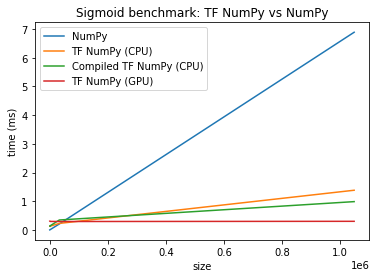

In [25]:
# Here we define a simple implementation of `sigmoid`, and benchmark it using
# NumPy and TensorFlow NumPy for different input sizes.

def np_sigmoid(y):
  return 1. / (1. + np.exp(-y))

def tnp_sigmoid(y):
  return 1. / (1. + tnp.exp(-y))

@tf.function
def compiled_tnp_sigmoid(y):
  return tnp_sigmoid(y)

sizes = (2**0, 2 ** 5, 2 ** 10, 2 ** 15, 2 ** 20)
np_inputs = [np.random.randn(size).astype(np.float32) for size in sizes]
np_times = benchmark(np_sigmoid, np_inputs)

with tf.device("/device:CPU:0"):
  tnp_inputs = [tnp.random.randn(size).astype(np.float32) for size in sizes]
  tnp_times = benchmark(tnp_sigmoid, tnp_inputs)
  compiled_tnp_times = benchmark(compiled_tnp_sigmoid, tnp_inputs)

has_gpu = len(tf.config.list_logical_devices("GPU"))
if has_gpu:
  with tf.device("/device:GPU:0"):
    tnp_inputs = [tnp.random.randn(size).astype(np.float32) for size in sizes]
    tnp_times_gpu = benchmark(compiled_tnp_sigmoid, tnp_inputs, 100, True)
else:
  tnp_times_gpu = None
plot(np_times, tnp_times, compiled_tnp_times, has_gpu, tnp_times_gpu)